# Проект Дашборд конверсий

## ШАГ 1 Подготовка к работе с данными

In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import matplotlib.colors as matcol
from dotenv import load_dotenv
from pathlib import Path

## ШАГ 2 Запросы к API

### Запрос на данные по посещениям от даты 2023-03-01 до даты 2023-09-01:

In [6]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [7]:
visit_json = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
#visit_json=requests.get("https://data-charts-api.hexlet.app/visits?begin=2022-03-01&end=2023-09-01") #запрос по API по URL
data_vis=visit_json.json() #перевод в JSON
df_visits=pd.DataFrame(data_vis) #перевод JSON в DataFrame
#df_visits.head(2000000)

### Запрос на данные по регистрациям от даты 2023-03-01 до даты 2023-09-01:

In [14]:
registration_json = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
#registration_json=requests.get("https://data-charts-api.hexlet.app/registrations?begin=2022-03-01&end=2023-09-01")
data_reg=registration_json.json()
df_registrations=pd.DataFrame(data_reg)
#df_registrations.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760


## ШАГ 3 Расчет метрик

### Фильтрация данных по визитам (убрать ботов) и группировка по датам и платформам:

In [17]:
def clean_agr_visits(df):
    df_cleaned=df.copy()
    df_cleaned['visit_dt']=pd.to_datetime(df_cleaned['datetime'])
    df_cleaned=df_cleaned.sort_values(by='visit_dt')
    df_cleaned['user_agent']=df_cleaned['user_agent'].fillna("")
    df_cleaned = df_cleaned[~df_cleaned['user_agent'].str.contains('bot')]
    df_cleaned['platform']=df_cleaned['platform'].str.strip("'")
    df_cleaned['date_group']=df_cleaned['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    df_cleaned=df_cleaned.groupby(['date_group', 'platform']).size().reset_index(name='visits')
    return df_cleaned

clean_agr_visits=clean_agr_visits(df_visits)
#clean_agr_visits.head(2000000)

### Фильтрация данных по регистрации и группировка по датам и платформам:

In [18]:
def clean_agr_registration(df):
    df_cleaned = df.drop_duplicates()
    df_cleaned['platform']= df_cleaned['platform'].fillna('web')
    df_cleaned['registration_dt']=pd.to_datetime(df_cleaned['datetime'])
    df_cleaned['date_group']=df_cleaned['registration_dt'].dt.to_period('D').dt.start_time.dt.date
    df_cleaned=df_cleaned.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
    return df_cleaned

clean_agr_registration=clean_agr_registration(df_registrations)
#clean_agr_registration.head(200000)

### Соединение новых датасетов посещений и регистраций:

In [19]:
def visits_and_registrations(clean_agr_visits, clean_agr_registration):
    merged_df=pd.merge(clean_agr_visits, clean_agr_registration, on=['date_group', 'platform'])
    return merged_df

vis_regs = visits_and_registrations(clean_agr_visits, clean_agr_registration)
#vis_regs.head(1000)

### Расчет конверсии сайта:

In [20]:
def conversion(vis_regs):
    vis_regs['conversion'] = (vis_regs['registrations'] / vis_regs['visits'] * 100).round(2)
    return vis_regs
vis_reg_conversion = conversion(vis_regs)
#vis_reg_conversion = vis_reg_conversion.sort_values(by='date_group', ascending=True)
vis_reg_conversion.to_json('conversion.json')
#vis_reg_conversion.head(1000)

## ШАГ 4 Присоединение рекламы 

### Добавление и подготовка данных по рекламным кампаниям из файла ads.csv:

In [21]:
def clean_ads_csv(ads):
    ads = ads.drop_duplicates()
    ads['date'] = pd.to_datetime(ads['date'], format='mixed')
    ads['date'] = ads['date'].dt.to_period('D').dt.start_time.dt.date
    #ads['date'] = ads['date'].dt.strftime('%Y-%m-%d')
    ads = ads.rename(columns={'date': 'date_group'})
    ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
    ads['cost'] = ads['cost'].fillna('0')
    return ads

ads = pd.read_csv('./ads.csv')

cleaned_ads = clean_ads_csv(ads)
#cleaned_ads.head(200)

In [22]:
def ads_agr(df, date1, date2):
    date1 = pd.to_datetime(date1).date()
    date2 = pd.to_datetime(date2).date()
    filtered_df=df[(df['date_group'] >= date1) & (df['date_group'] <= date2)]
    ads_agr =  filtered_df.groupby(['date_group', 'utm_campaign']).sum(['cost']).reset_index()
    return ads_agr

ads_agr = ads_agr(cleaned_ads, DATE_BEGIN, DATE_END)
#ads_agr.head(200)

### Объединение датасетов расчета конверсии и рекламных кампаний: 

In [23]:
def merged_conv_ads(vis_reg_conversion, cleaned_ads):
    conv_ads = pd.merge(
        vis_reg_conversion, cleaned_ads,
        left_on='date_group',
        right_on='date_group',
        how='left')
    conv_ads.loc[conv_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
    conv_ads = conv_ads.sort_values(by='date_group', ascending=True)
    #conv_ads.reset_index(drop=True, inplace=True)
    conv_ads = conv_ads[['date_group', 'platform', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
    conv_ads.to_json('ads.json')
    return conv_ads

conv_ads = merged_conv_ads(vis_reg_conversion, cleaned_ads)
#conv_ads.head(2000)

# ШАГ 5 Визуализация

### Подготовка данных для визуализации

In [24]:
def weekly_data(df):
    conv_wee = df.copy()
    conv_wee['date_week'] = pd.to_datetime(conv_wee['date_group'])
    conv_wee['date_week'] = conv_wee['date_week'].dt.to_period('W').dt.start_time.dt.date
    conv_week_platform = conv_wee.groupby(['date_week', 'platform']).sum(['visits', 'registrations']).reset_index()
    conv_week = conv_wee.groupby(['date_week']).sum(['visits', 'registrations']).reset_index()
    conv_week_platform['conversion'] = (conv_week_platform['registrations'] /conv_week_platform['visits']) * 100
    conv_week['conversion'] = (conv_week['registrations'] / conv_week['visits']) * 100
    return conv_week, conv_week_platform

conv_week, conv_week_platform = weekly_data(conv_ads)
#conv_week.head()

In [25]:
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

## Итоговые визиты

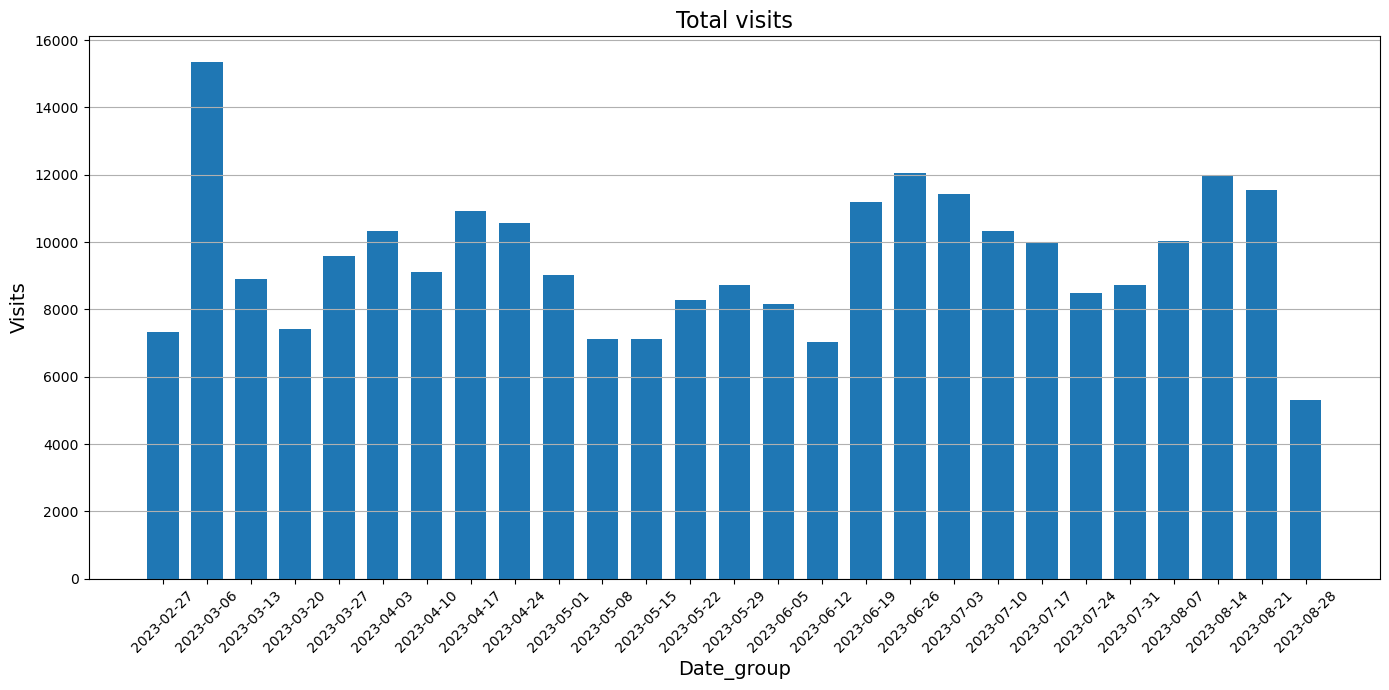

In [26]:
def total_visits(df):
    fig, ax = plt.subplots(figsize=(14,7))
    bars = plt.bar(x='date_week', height='visits', data=df, width=5)
    #ax.bar_label(bars)
    plt.title('Total visits', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Visits', fontsize=14)
    plt.xticks(df['date_week'], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"./charts/total_visits.png")

total_visits(conv_week)

## Итоговые визиты с разбивкой по платформам: web, android, ios

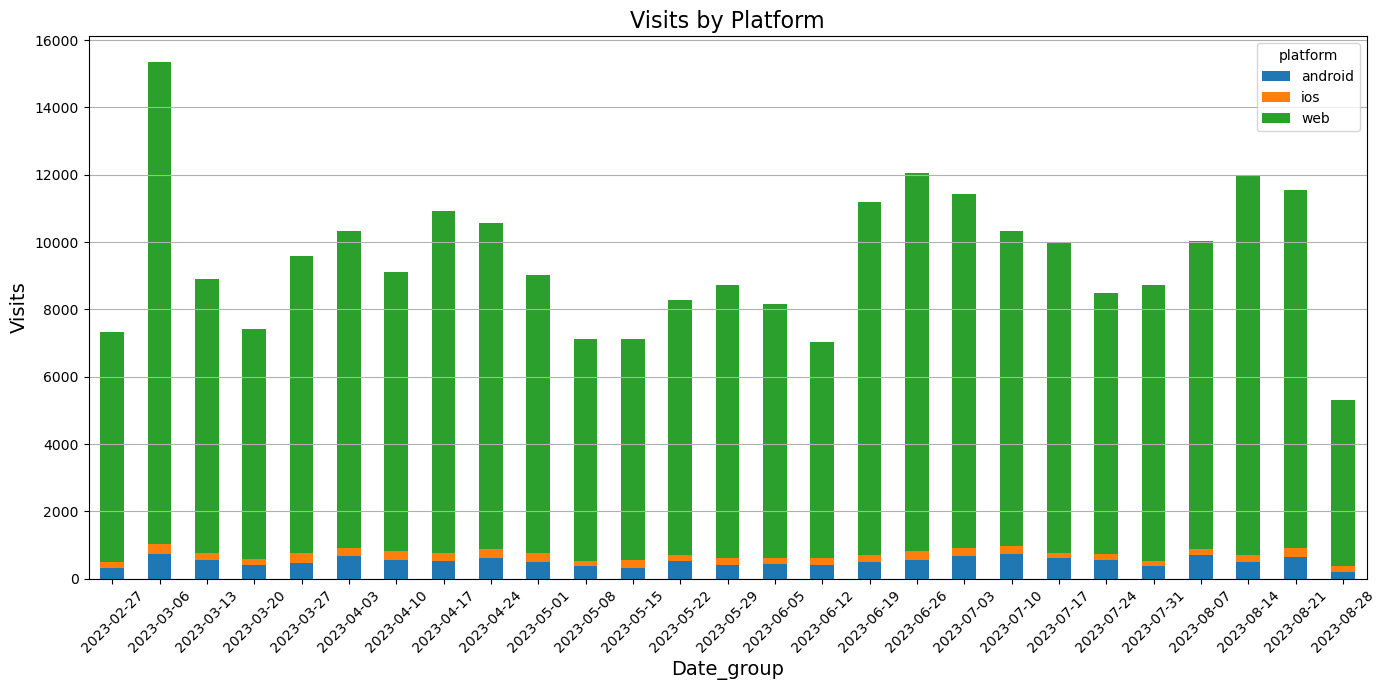

In [27]:
def total_visits_pltfm_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = df.pivot_table(index='date_week', columns='platform', values='visits')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Visits by Platform', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Visits',fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"./charts/Total_visits_platform.png")

total_visits_pltfm_chart(conv_week_platform)



## Итоговые регистрации

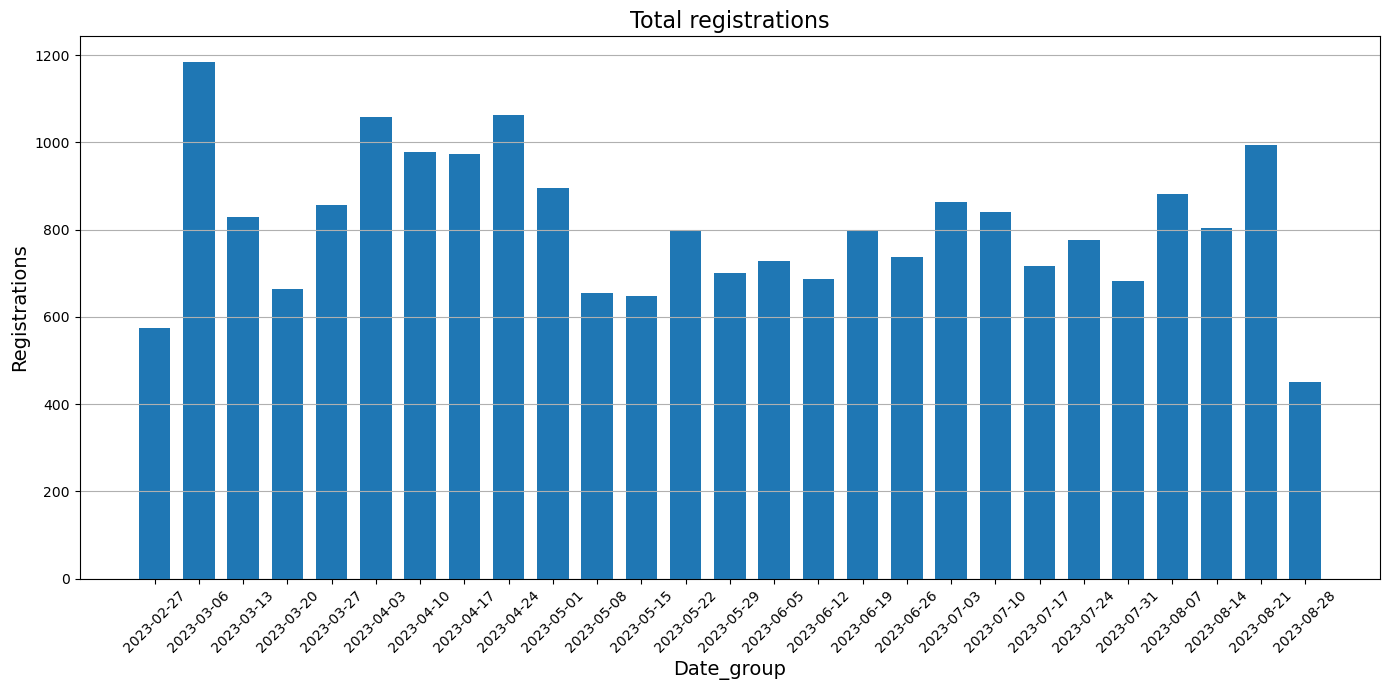

In [28]:
def total_registrations(df):
    fig, ax = plt.subplots(figsize=(14,7))
    bars = plt.bar(x='date_week', height='registrations', data=df, width=5)
    #ax.bar_label(bars)
    plt.title('Total registrations', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Registrations', fontsize=14)
    plt.xticks(df['date_week'], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{d}/Total_registrations.png")

total_registrations(conv_week)

## Итоговые регистрации с разбивкой по платформе: web, android, ios

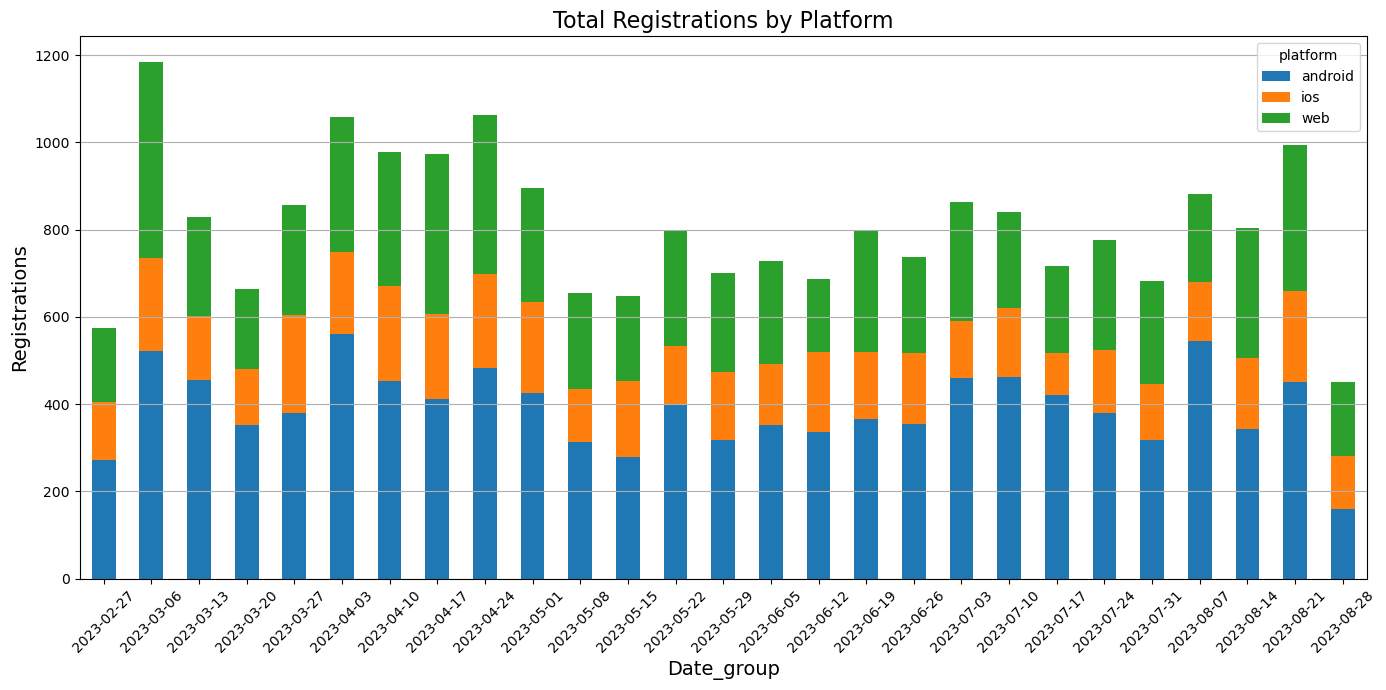

In [29]:
def total_registrations_platform(df):
    fig, ax = plt.subplots(figsize=(14,7))
    cnv_ads_pvt1 = df.pivot_table(index='date_week', columns='platform', values='registrations')
    cnv_ads_pvt1.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Total Registrations by Platform', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Registrations', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"./charts/Total_registrations_by_platform.png")
    

total_registrations_platform(conv_week_platform)


### Круговая диаграмма по типу регистраций

In [30]:
registrations_by_platform = vis_regs.groupby('platform')['registrations'].sum().reset_index()
#print(registrations_by_platform)


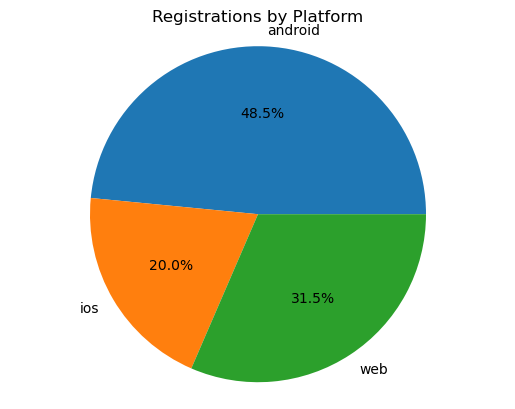

<Figure size 640x480 with 0 Axes>

In [32]:
def pie_chart_for_registrations(registrations_by_platform):
    fig, ax = plt.subplots()
    ax.pie(registrations_by_platform['registrations'], labels=registrations_by_platform['platform'], autopct='%1.1f%%')
    ax.axis('equal')  

    plt.title('Registrations by Platform')
    plt.show()
    plt.savefig(f"./charts/Pie_chart_for_reg.png")


pie_chart_for_registrations(registrations_by_platform)

## Конверсия по каждой платформе

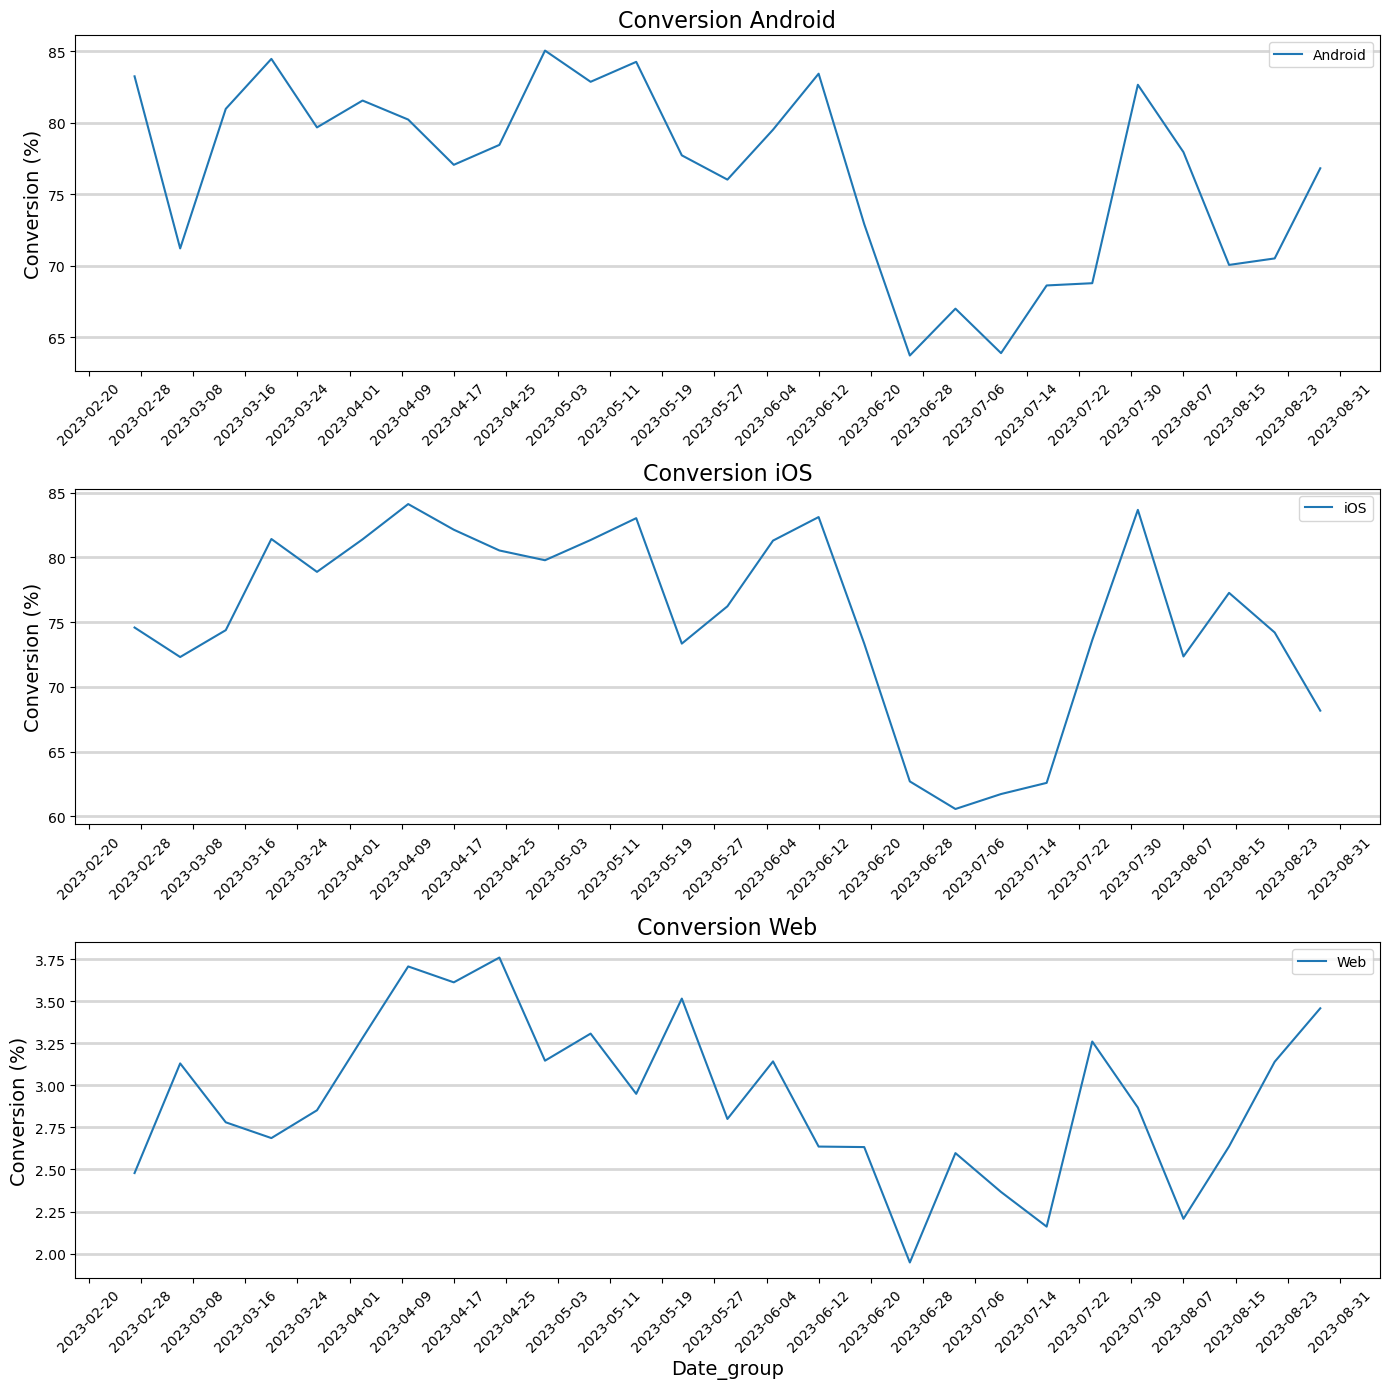

In [33]:
visregconv = conv_week_platform.copy(deep=True)

android_data = visregconv[visregconv['platform'] == 'android']
ios_data = visregconv[visregconv['platform'] == 'ios']
web_data = visregconv[visregconv['platform'] == 'web']

fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=False, sharey=False)

axs[0].plot(android_data['date_week'], android_data['conversion'], label='Android')
axs[0].set_title('Conversion Android', fontsize=16)
axs[0].set_ylabel('Conversion (%)', fontsize=14)
axs[0].legend()
axs[0].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[0].tick_params(axis='x', rotation=45)  
axs[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

axs[1].plot(ios_data['date_week'], ios_data['conversion'], label='iOS')
axs[1].set_title('Conversion iOS', fontsize=16)
axs[1].set_ylabel('Conversion (%)', fontsize=14)
axs[1].legend()
axs[1].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[1].tick_params(axis='x', rotation=45) 
axs[1].xaxis.set_major_locator(plt.MaxNLocator(nbins=30)) 

axs[2].plot(web_data['date_week'], web_data['conversion'], label='Web')
axs[2].set_title('Conversion Web', fontsize=16)
axs[2].set_xlabel('Date_group', fontsize=14)
axs[2].set_ylabel('Conversion (%)', fontsize=14)
axs[2].legend()
axs[2].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
axs[2].tick_params(axis='x', rotation=45) 
axs[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

plt.tight_layout()

plt.savefig(f"./charts/conversion_platform_chart.png")

plt.show()



## Средняя конверсия

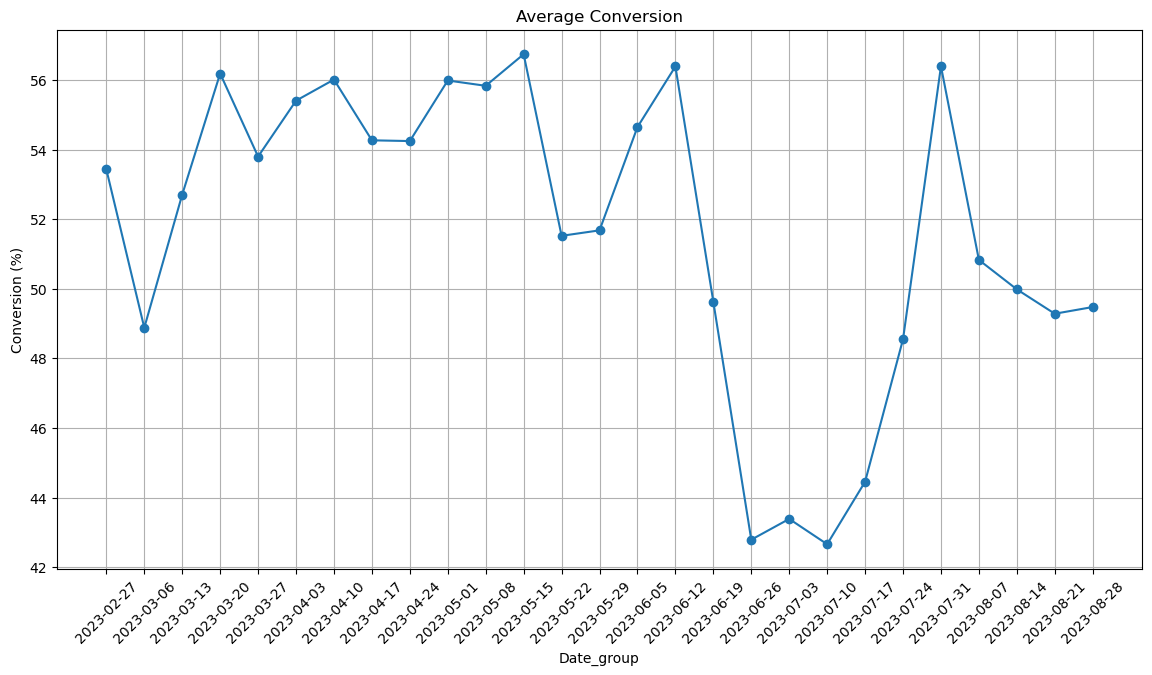

In [34]:
def avg_conversion(df):
    avg_conv_chart = df.groupby('date_week')['conversion'].mean().plot(figsize=(14,7), style='o-', grid=True)
    plt.title('Average Conversion')
    plt.xlabel('Date_group')
    plt.ylabel('Conversion (%)')
    plt.xticks(df['date_week'].unique(), rotation=45)
    plt.savefig(f"./charts/Avg_conversion.png")

avg_conversion(conv_week_platform)



## Стоимости реклам

In [35]:
conv_week = conv_ads.copy()
conv_week['date_week'] = pd.to_datetime(conv_week['date_group'])
conv_week['date_week'] = conv_week['date_week'].dt.to_period('W').dt.start_time.dt.date
conv_week = conv_week.groupby(['date_week', 'utm_campaign']).sum(['visits', 'registrations', 'cost']).reset_index()
conv_week['conversion'] = (conv_week['registrations'] / conv_week['visits']) * 100
#conv_week.head()

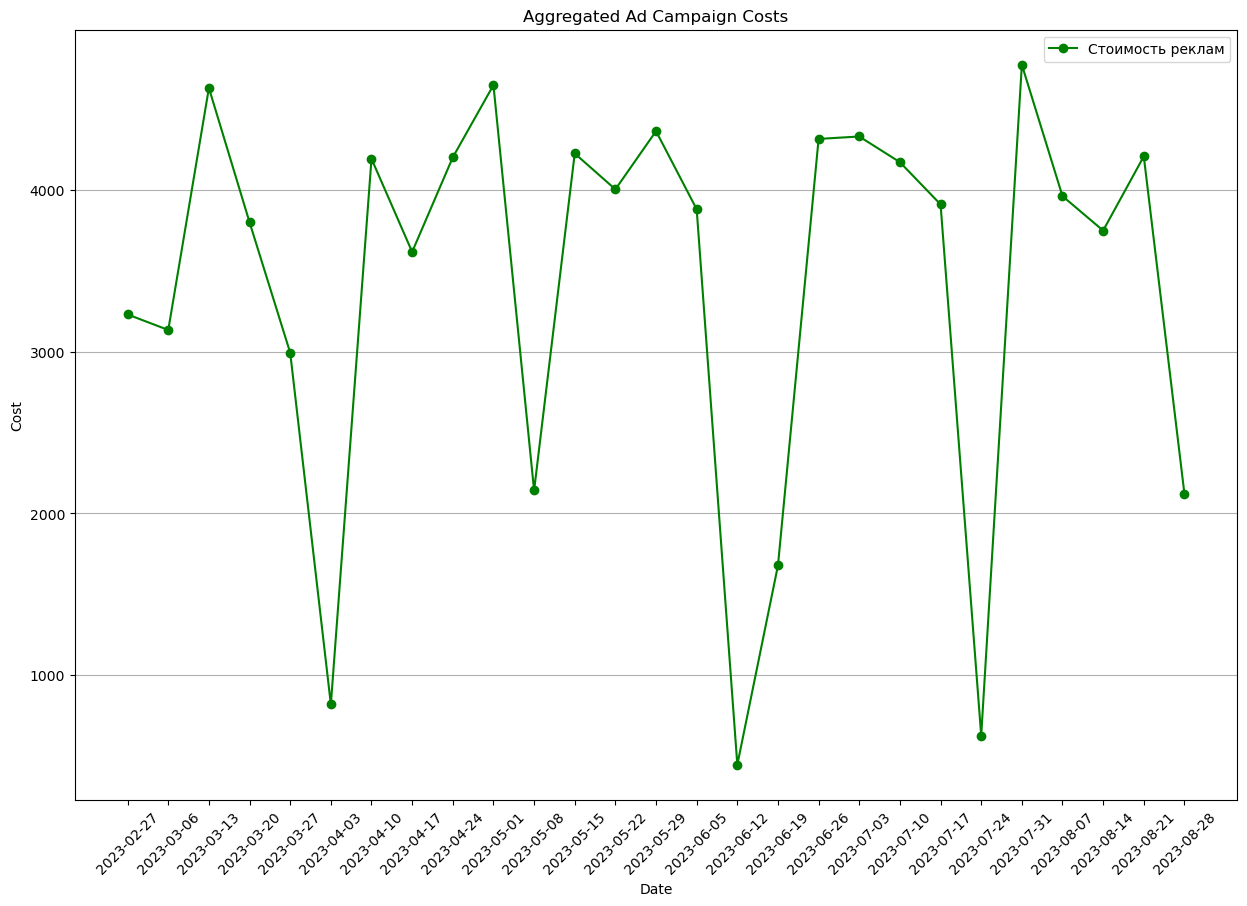

In [36]:
def adscosts(df):
    adcosts = df.groupby('date_week')['cost'].mean().reset_index()
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    x = adcosts['date_week']
    y = adcosts['cost']
    ax.plot(x, y,
            marker="o",
            c="g",
            label='Стоимость реклам',
            linewidth=1.5,
            markersize=6)
    '''for x,y in zip(x,y):
        label = "{:.0f}%".format(y)
        plt.annotate(label,
                     (x,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')'''
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Cost')
    ax.grid(axis='y')
    plt.title('Aggregated Ad Campaign Costs')
    plt.xticks(adcosts['date_week'], rotation=45)
    plt.savefig(f"./charts/Adcosts.png")
adscosts(conv_week)

## Визиты и регистрациии за весь период с цветовым выделением рекламной кампании

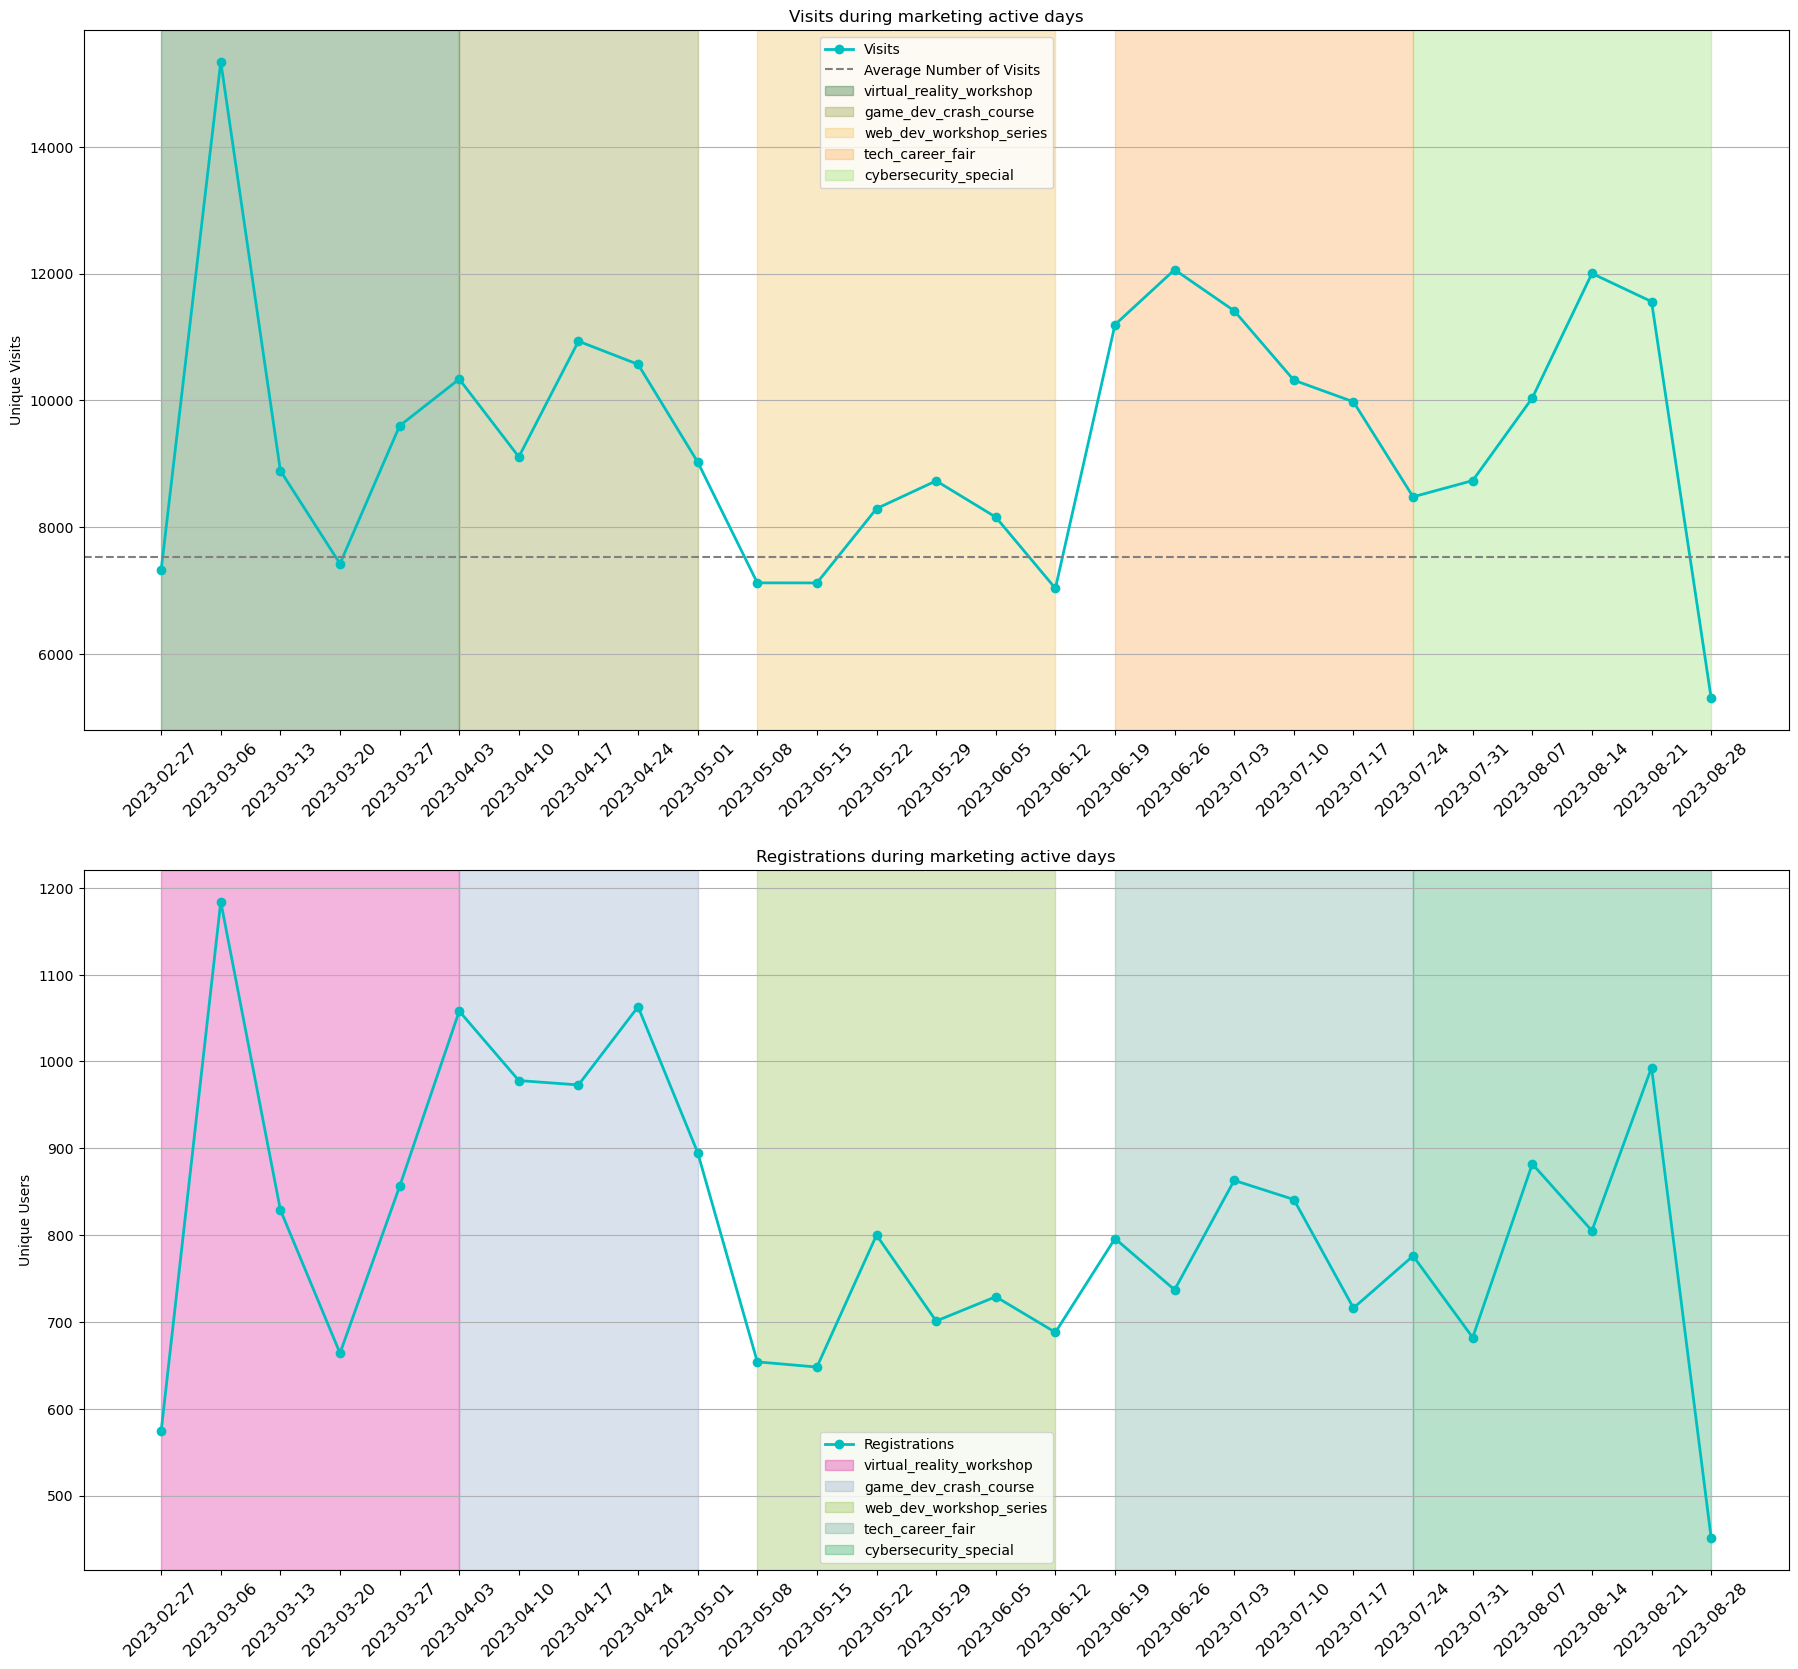

In [37]:
campaign_days = conv_week[['date_week', 'utm_campaign']]
virtual_reality_workshop = campaign_days.loc[campaign_days['utm_campaign'] == 'virtual_reality_workshop']
start_date = virtual_reality_workshop['date_week'].min()
end_date = virtual_reality_workshop['date_week'].max()

game_dev_crash_course = campaign_days.loc[campaign_days['utm_campaign'] == 'game_dev_crash_course']
start_date = game_dev_crash_course['date_week'].min()
end_date = game_dev_crash_course['date_week'].max()

web_dev_workshop_series = campaign_days.loc[campaign_days['utm_campaign'] == 'web_dev_workshop_series']
start_date = web_dev_workshop_series['date_week'].min()
end_date = web_dev_workshop_series['date_week'].max()

tech_career_fair = campaign_days.loc[campaign_days['utm_campaign'] == 'tech_career_fair']
start_date = tech_career_fair['date_week'].min()
end_date = tech_career_fair['date_week'].max()

cybersecurity_special = campaign_days.loc[campaign_days['utm_campaign'] == 'cybersecurity_special']
start_date = cybersecurity_special['date_week'].min()
end_date = cybersecurity_special['date_week'].max()    

periods_of_ads = pd.DataFrame(columns=['start_date', 'end_date', 'utm_campaign'])
periods_of_ads['start_date'] = [virtual_reality_workshop['date_week'].min(), game_dev_crash_course['date_week'].min(), web_dev_workshop_series['date_week'].min(), tech_career_fair['date_week'].min(), cybersecurity_special['date_week'].min()]
periods_of_ads['end_date'] = [virtual_reality_workshop['date_week'].max(), game_dev_crash_course['date_week'].max(), web_dev_workshop_series['date_week'].max(), tech_career_fair['date_week'].max(), cybersecurity_special['date_week'].max()]
periods_of_ads['utm_campaign'] = ['virtual_reality_workshop', 'game_dev_crash_course', 'web_dev_workshop_series', 'tech_career_fair', 'cybersecurity_special']


def vis_regist_campaign_chart(df):
    fig, axes = plt.subplots(2, 1, figsize=(22,20))
    visits_campaign = df.groupby(['date_week'])['visits'].sum().reset_index()
    x = visits_campaign['date_week']
    y = visits_campaign['visits']
    axes[0].plot(x, y,
            marker="o",
            c="c",
            label='Visits',
            linewidth=2,
            markersize=6)
    avg_visits = df['visits'].mean()
    axes[0].axhline(y=avg_visits, color='gray', linestyle='dashed', label='Average Number of Visits')
    ads_started = periods_of_ads['start_date'].to_list()
    ads_ended = periods_of_ads['end_date'].to_list()
    for i in range(len(ads_started)):
        axes[0].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[0].set_title('Visits during marketing active days')
    axes[0].set_ylabel('Unique Visits')
    axes[0].set_xticks(visits_campaign['date_week'])
    axes[0].set_xticklabels(visits_campaign['date_week'], fontsize=12, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y')
    registr_campaign = conv_week.groupby(['date_week'])['registrations'].sum().reset_index()
    x3 = registr_campaign['date_week']
    y3 = registr_campaign['registrations']
    axes[1].plot(x3, y3,
            marker="o",
            c="c",
            label='Registrations',
            linewidth=2,
            markersize=6)
    avg_registrations = conv_ads['registrations'].mean()
    for i in range(len(ads_started)):
        axes[1].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[1].set_title('Registrations during marketing active days')
    axes[1].set_ylabel('Unique Users')
    axes[1].set_xticks(registr_campaign['date_week'])
    axes[1].set_xticklabels(registr_campaign['date_week'], fontsize=12, rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y')
    plt.savefig(f"./charts/Visits_and_registrations_chart.png")
vis_regist_campaign_chart(conv_week)

# Для презентации

In [38]:
def aggregate_ads_by_campaign(ads):
    aggregated_ads = ads.groupby('utm_campaign')['cost'].sum().reset_index()

    return aggregated_ads

aggregated_ads = aggregate_ads_by_campaign(cleaned_ads)
#aggregated_ads.head(200)

In [39]:
def total_visits_over_time(df):
    df_cleaned = df.copy()
    df_cleaned['visit_dt'] = pd.to_datetime(df_cleaned['datetime'])
    df_cleaned = df_cleaned.sort_values(by='visit_dt')
    df_cleaned['user_agent'] = df_cleaned['user_agent'].fillna("")
    df_cleaned = df_cleaned[~df_cleaned['user_agent'].str.contains('bot')]
    df_cleaned['platform'] = df_cleaned['platform'].str.strip("'")
    df_cleaned['date_group'] = df_cleaned['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    total_visits = df_cleaned['visit_id'].nunique()
    return total_visits

total_visits = total_visits_over_time(df_visits)
#print("Total Visits:", total_visits)


In [40]:
def average_visits_per_day(df_visits):
    df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
    df_visits['date_group'] = df_visits['datetime'].dt.to_period('D').dt.start_time.dt.date
    avg_visits_per_day = df_visits.groupby('date_group')['visit_id'].count().mean()
    return avg_visits_per_day

average_visits_per_day = average_visits_per_day(df_visits)
#print(f"Average number of visit_id visitors per day: {average_visits_per_day}")